___
<img style="float: right; margin: 15px 15px 15px 15px;" src="https://img.freepik.com/free-photo/shop-clothing-clothes-shop-hanger-modern-shop-boutique_1150-8886.jpg" width="380px" height="200px" />


# <font color= #bbc28d> **Project 1 - Autoencoders** </font>
#### <font color= #2E9AFE> `Variational Autoencoder`</font>

<br><br><br>
___

<p style="text-align:right; font-size:12px;" > Image retrieved from: "https://img.freepik.com/free-photo/shop-clothing-clothes-shop-hanger-modern-shop-boutique_1150-8886.jpg</p>

# <font color=#bbc28d> **Introduction** </font>
Variational Autoencoders **(VAEs)** are a class of deep learning models designed for unsupervised learning and generating new data. They build upon traditional autoencoders by introducing probabilistic methods, enabling them to produce data that closely resembles the original training set.

Unlike conventional autoencoders, which primarily focus on compressing and reconstructing input data, VAEs aim to learn the underlying probability distribution. This capability makes them valuable for tasks such as image synthesis, anomaly detection, data compression, and extracting meaningful features.

By utilizing a latent space representation, VAEs can generate varied and realistic outputs while preserving a structured, continuous, and interpretable encoding of the data.

**`Note`**: Due to local hardware and storage limitations, all data cleaning and preprocessing steps in this notebook were executed using Google Colab.

In [ ]:
# Import modules
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import pickle
import numpy as np
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, ops
from keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Flatten,Reshape, BatchNormalization, Lambda

# <font color=#bbc28d> **Environment Preparation** </font>

Google Drive is mounted into the Google Colab environment. This allows the notebook to directly access files stored in cloud storage, such as datasets and preprocessed outputs.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# <font color=#bbc28d> **Data Preparation** </font>
Here we extract the compressed dataset archive stored in Google Drive into the Colab filesystem. This step makes the image files and metadata accessible for preprocessing without requiring repeated downloads.

For VAEs, we don´t really need the labels, however, since we want to visualize and see the difference in between groups, we will also download them.

**`Note:`** The labels aren´t that heavy so dowloading them or not won't make a big difference in the computer's disk.

In [3]:
# Load everything back
X = np.load("/content/drive/MyDrive/processed/X_images.npy")
y = np.load("/content/drive/MyDrive/processed/y_labels.npy")

with open("/content/drive/MyDrive/processed/label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

print(X.shape)
print(y.shape)

(2906, 256, 256, 3)
(2906,)


With our whole dataset ready to use, we split it into our train/test sets to be able to train and evaluate our model's performances:

Training data shapes: X=(2324, 256, 256, 3), y=(2324,)
Testing data shapes: X=(582, 256, 256, 3), y=(582,)


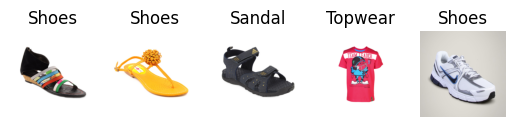

In [ ]:
# Split both images and labels together
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  # stratify keeps label distribution

print('Training data shapes: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Testing data shapes: X=%s, y=%s' % (x_test.shape, y_test.shape))

# Plot 5 random images
for j in range(5):
    i = np.random.randint(0, x_train.shape[0])
    plt.subplot(1, 5, j+1)
    plt.imshow(x_train[i])
    plt.title(le.inverse_transform([y_train[i]])[0])  # <Take first element
    plt.axis('off')
plt.show()

# <font color=#bbc28d> **Loss Functions** </font>
In a Variational Autoencoder, the loss function tells the model what it should optimize during training. Unlike a standard autoencoder, a VAE **does not use a single reconstruction error** as its loss. 

In probabilistic generative models, the main goal is to make the model assign **high probability** to the observed data. This objective is expressed by maximizing the **log-likelihood**:

$$
\log p_\theta(x)
$$

However, in Variational Autoencoders this quantity is **impossible** to compute directly because it requires integrating over all possible latent variables $z$:

$$
\log p_\theta(x)
=
\log \int p_\theta(x, z)\, dz
$$

This integral is computationally expensive or impossible to evaluate exactly for neural networks. To address this issue, **variational inference** introduces an approximate posterior distribution $q_\phi(z \mid x)$ and derives a tractable lower bound on the log-likelihood, known as the **Evidence Lower Bound (ELBO)**.

## <font color= #66b0b0>• **The Two Components of the ELBO** </font>

#### **Reconstruction Loss**
This term measures how close the decoder’s output is to the original input. Its role is to ensure that the latent variable `z` contains enough information to faithfully reconstruct the data.

Conceptually, this term encourages the encoder and decoder to behave like a **compression–decompression system**, preserving the most important information needed to reconstruct the input.

#### **Kullback–Leibler (KL) Divergence Loss**
This term measures how far the learned latent distribution $q(z \mid x)$ is from the prior distribution $p(z)$, which is usually chosen as a standard normal distribution. Its purpose is not reconstruction, but **regularization**. By penalizing large deviations from the prior, the KL divergence encourages the latent space to be smooth, continuous, and well-organized, ensuring that nearby latent vectors decode to similar outputs. This regularization is what makes **sampling and generation** possible in Variational Autoencoders.

# <font color=#bbc28d> **Reconstruction Loss** </font>
In practice, the choice of **reconstruction loss** depends on the nature of the data and the modeling goals. Two of the most common choices are **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)**. In our case, we will be using both of these metrics to be able to analyze the difference between both metrics of reconstruction and which one adapts well to our case.

## <font color= #66b0b0>• **Mean Squared Error (MSE)** </font>
It strongly **penalizes large reconstruction errors** due to the squared term, which encourages the model to focus on correcting large deviations between the input and the reconstruction.
  
Tends to produce sharper reconstructions and emphasizes pixel-wise accuracy. However, it is more sensitive to outliers and can lead the model to prioritize reconstruction quality over latent space regularization if not balanced properly with the KL term.

$$
\mathcal{L}_{\text{MSE}}(x, \hat{x}) = \frac{1}{N} \sum_{i=1}^{N} (x_i - \hat{x}_i)^2
$$

**`Note`**: In later versions of keras [we worked on Keras 3] the dual loss functions have to be specified using a class object rather than passing it directly.

In [ ]:
# VAE MODEL [MANUAL/MEAN MSE + KL]
class VAE_MSEM_KL(tf.keras.Model):
    def __init__(self, encoder, decoder, beta=1):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

        # Metrics
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="mse")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl")
        self.elbo_tracker = tf.keras.metrics.Mean(name="elbo")

    @property
    def metrics(self):
        return [
            self.recon_loss_tracker,
            self.kl_loss_tracker,
            self.elbo_tracker,
        ]

    def call(self, inputs, training=False):
        z_mean, z_log_var, z = self.encoder(inputs, training=training)
        return self.decoder(z, training=training)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data, training=True)
            reconstruction = self.decoder(z, training=True)

            # MSE reconstruction loss
            recon_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(data - reconstruction),
                    axis=(1, 2, 3)
                )
            )

            # KL divergence
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1
                )
            )

            elbo = recon_loss + self.beta * kl_loss

        grads = tape.gradient(elbo, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.elbo_tracker.update_state(elbo)

        return {
            "mse": self.recon_loss_tracker.result(),
            "kl": self.kl_loss_tracker.result(),
            "elbo": self.elbo_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, z = self.encoder(data, training=False)
        reconstruction = self.decoder(z, training=False)

        # MSE reconstruction loss
        recon_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.square(data - reconstruction),
                axis=(1, 2, 3)
            )
        )

         # KL divergence
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1
            )
        )

        elbo = recon_loss + self.beta * kl_loss

        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.elbo_tracker.update_state(elbo)

        return {
            "val-mse": self.recon_loss_tracker.result(),
            "val-kl": self.kl_loss_tracker.result(),
            "val-elbo": self.elbo_tracker.result(),
        }

## <font color= #66b0b0>• **Mean Absolute Error (MAE)** </font>
It penalizes reconstruction errors linearly, making it less sensitive to large errors compared to MSE.
 
MAE is more robust to outliers and often produces smoother reconstructions, it often also ends in less washed-out colors.

$$
\mathcal{L}_{\text{MAE}}(x, \hat{x}) = \frac{1}{N} \sum_{i=1}^{N} \lvert x_i - \hat{x}_i \rvert
$$

In [ ]:
class VAE_MAE_KL(tf.keras.Model):
    def __init__(self, encoder, decoder, beta=3):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

        # Keras MAE loss
        self.mae_loss_fn = tf.keras.losses.MeanAbsoluteError()

        # Metrics
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="mae")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl")
        self.elbo_tracker = tf.keras.metrics.Mean(name="elbo")

    @property
    def metrics(self):
        return [
            self.recon_loss_tracker,
            self.kl_loss_tracker,
            self.elbo_tracker,
        ]

    def call(self, inputs, training=False):
        z_mean, z_log_var, z = self.encoder(inputs, training=training)
        return self.decoder(z, training=training)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data, training=True)
            reconstruction = self.decoder(z, training=True)

            # MAE reconstruction loss
            abs_error = tf.abs(data - reconstruction)

            recon_loss = tf.reduce_mean(tf.reduce_sum(abs_error, axis=[1, 2, 3]))

            # KL divergence
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1))

            # ELBO
            elbo = recon_loss + self.beta * kl_loss

        grads = tape.gradient(elbo, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.elbo_tracker.update_state(elbo)

        return {
            "mae": self.recon_loss_tracker.result(),
            "kl": self.kl_loss_tracker.result(),
            "elbo": self.elbo_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, z = self.encoder(data, training=False)
        reconstruction = self.decoder(z, training=False)

        # Recon Loss MAE
        abs_error = tf.abs(data - reconstruction)

        recon_loss = tf.reduce_mean(
            tf.reduce_sum(abs_error, axis=[1, 2, 3]))


        # KL divergence
        kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1))

        elbo = recon_loss +  self.beta * kl_loss

        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.elbo_tracker.update_state(elbo)

        return {
            "mae": self.recon_loss_tracker.result(),
            "kl": self.kl_loss_tracker.result(),
            "elbo": self.elbo_tracker.result(),
        }

# <font color=#bbc28d> **Re-parametrization trick** </font>

In Variational Autoencoders, the encoder doesn’t produce a single latent vector but instead outputs the parameters of a distribution — `z_mean and z_log_var`. 

The problem is that to get a latent vector, we need to **sample** from this distribution, and sampling is a **random operation**, which prevents gradients from flowing through the network during training. Without gradients, the encoder cannot learn how to adjust its outputs to produce better reconstructions. 

The reparameterization trick solves this by rewriting the sampled latent vector as a deterministic function of the encoder outputs plus separate random noise:

$$
z = z\_mean + \exp(0.5 \times z\_log\_var) \times \epsilon
$$ 
 
Where $\epsilon$ is drawn from a standard normal distribution. Here, `z_mean` and `z_log_var` are **deterministic**—they always produce the same values for a given input—so gradients can flow through them, while the randomness is isolated in `ε`.  

This formulation allows the network to **learn effectively** while still generating latent vectors that include the necessary randomness.


In [6]:
def sampling(inputs):
    # They come from the dense layer of the encoder
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]

    # Epsilon is a Normal distribution N(0,1) of the shape of the latent_dimension
    epsilon = tf.keras.backend.random_normal(shape =(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# <font color=#bbc28d> **Model architecture and setup** </font>
We evaluated two different VAE architectures: a **simple convolutional model** and a **more complex model**. Both follow the same encoder–decoder principle but differ in depth, layer composition, and feature compression strategy.

---
## <font color= #66b0b0>• **Experiment Process** </font>

For each architecture:
- We trained **three models using MAE** and **three models using MSE** as reconstruction losses.
- Each loss configuration was evaluated with **latent dimensions of 2, 64, and 128**.
- This resulted in **6 models per architecture** and **12 models total**.

To determine the best model, we compared:
- Reconstruction loss curves (train and validation)
- **Structural Similarity Index Measure (SSIM)** scores


## <font color= #66b0b0>• **Simple model architecture** </font>
The images are progressively downsampled through multiple simple convolutional layers:

In [7]:
def build_encoder(input_shape=(256, 256, 3), latent_dim=64):
    """
    Encoder function which recieves 2 optional arguments.

    Args:
    input_shape: The input dimension specified for images (pixel, pixel, channels)
    latent_dim: The dimension to which we will reduce our images for the latent space
    """

    encoder_inputs = Input(shape=input_shape, name="encoder_input")

    x = Conv2D(32, 3, strides=2, padding="same", activation="relu")(encoder_inputs)   # 128x128x32
    x = Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)               # 64x64x64
    x = Conv2D(128, 5, strides=2, padding="same", activation="relu")(x)              # 32x32x128
    x = Conv2D(256, 5, strides=2, padding="same", activation="relu")(x)              # 16x16x256
    x = Conv2D(512, 3, strides=2, padding="same", activation="relu")(x)              # 8x8x512
    x = Flatten()(x)

    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)

    z = Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    return encoder

In [8]:
def build_decoder(latent_dim=64):
    """
    Decoder function which recieves 1 optional argument.

    Args:
    input_shape/latent_dim: Since we are sampling from the latent_dim, out input will be a vector of that size.
    """

    latent_inputs = Input(shape=(latent_dim,), name="Input_latent")
    x = Dense(8*8*512, activation="relu")(latent_inputs)
    x = Reshape((8, 8, 512))(x)

    x = Conv2DTranspose(256, 5, strides=2, padding="same", activation="relu")(x)   # 16x16x256
    x = Conv2DTranspose(128, 5, strides=2, padding="same", activation="relu")(x)   # 32x32x128
    x = Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)    # 64x64x64
    x = Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)    # 128x128x32
    decoder_outputs = Conv2DTranspose(3, 3, strides=2, padding="same", activation="sigmoid")(x)  # 256x256x3

    decoder = Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder

## <font color= #66b0b0>• **Simple model architecture - MSE - 2D** </font>

In [ ]:
# Build encoder dim=2d
encoder_base_2d = build_encoder(latent_dim=2)
encoder_base_2d.summary()

# Build decoder dim=2d
decoder_base_2d = build_decoder(latent_dim=2)
decoder_base_2d.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │        896 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     18,496 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    204,928 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │    819,456 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32768)     │          0 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │     65,538 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │     65,538 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,355,012 (8.98 MB)

 Trainable params: 2,355,012 (8.98 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_latent (InputLayer)       │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32768)          │        98,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 16, 16, 256)    │     3,277,056 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 32, 128)    │       819,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 256, 256, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,811 (16.36 MB)

 Trainable params: 4,287,811 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Initiate VAE Model and compile
vae_base_2d = VAE_MSEM_KL(encoder_base_2d, decoder_base_2d)
vae_base_2d.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

vae_base_2d.build((None, 256, 256, 3))
vae_base_2d.summary()

Model: "vae_msem_kl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 2), (None, 2), │     2,355,012 │
│                                 │ (None, 2))             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 256, 256, 3)    │     4,287,811 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,642,823 (25.34 MB)

 Trainable params: 6,642,823 (25.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_base_2d = vae_base_2d.fit(x_train, epochs=35, batch_size=16, shuffle=True, validation_split=0.1)

Epoch 1/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 35s 158ms/step - elbo: 30167.0508 - kl: 524.2913 - mse: 29642.7539 - val_val-elbo: 8769.4473 - val_val-kl: 167.2133 - val_val-mse: 8602.2344
Epoch 2/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - elbo: 8255.7910 - kl: 172.2299 - mse: 8083.5615 - val_val-elbo: 6628.3281 - val_val-kl: 121.0320 - val_val-mse: 6507.2974
Epoch 3/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - elbo: 6448.0386 - kl: 96.0481 - mse: 6351.9912 - val_val-elbo: 5943.5181 - val_val-kl: 60.0759 - val_val-mse: 5883.4414
Epoch 4/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - elbo: 5840.4004 - kl: 57.3648 - mse: 5783.0352 - val_val-elbo: 5675.7354 - val_val-kl: 52.8631 - val_val-mse: 5622.8721
Epoch 5/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - elbo: 5659.1841 - kl: 39.7528 - mse: 5619.4316 - val_val-elbo: 5499.6138 - val_val-kl: 34.3782 - val_val-mse: 5465.2354
Epoch 6/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - elbo: 5485.5273 - kl: 30.4482 - mse: 5455.0786 - val_val-elbo

In [ ]:
encoder_base_2d.save("/content/drive/MyDrive/processed/Models/encoder_mse_base_2d.keras")
decoder_base_2d.save("/content/drive/MyDrive/processed/Models/decoder_mse_base_2d.keras")

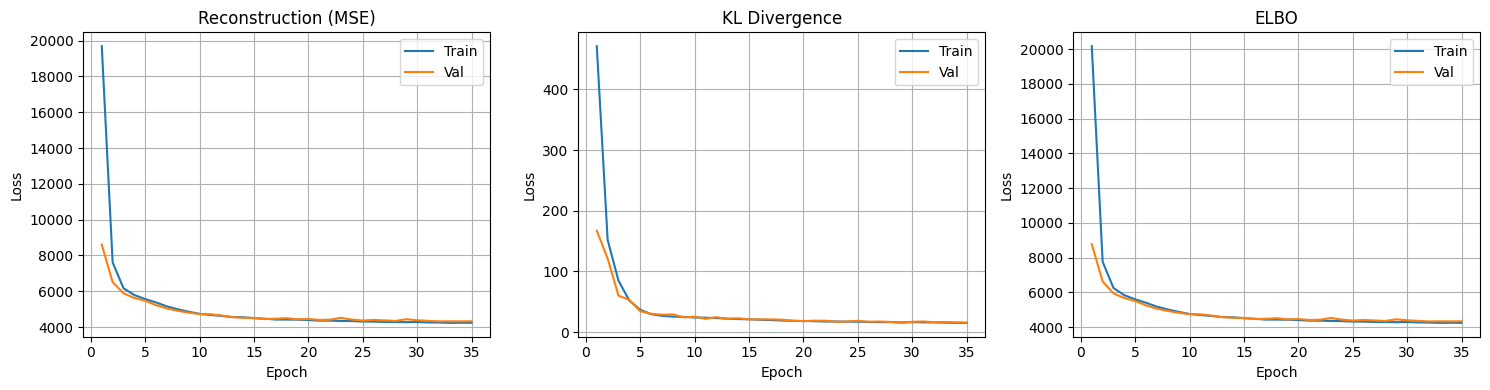

In [ ]:
epochs = range(1, len(history_base_2d.history["elbo"]) + 1)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Let's plot our MSE
axes[0].plot(epochs, history_base_2d.history["mse"], label="Train")
axes[0].plot(epochs, history_base_2d.history["val_val-mse"], label="Val")
axes[0].set_title("Reconstruction (MSE)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# Then we plot our KL
axes[1].plot(epochs, history_base_2d.history["kl"], label="Train")
axes[1].plot(epochs, history_base_2d.history["val_val-kl"], label="Val")
axes[1].set_title("KL Divergence")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

# And finally the ELBO [MSE + KL]
axes[2].plot(epochs, history_base_2d.history["elbo"], label="Train")
axes[2].plot(epochs, history_base_2d.history["val_val-elbo"], label="Val")
axes[2].set_title("ELBO")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


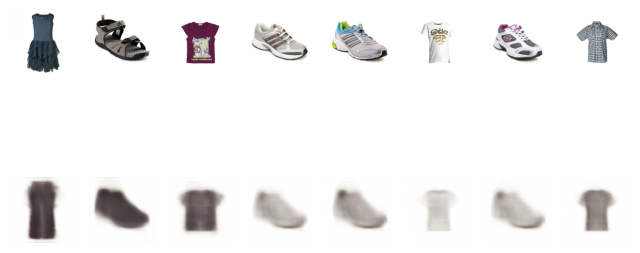

In [ ]:
recon_base_2d = vae_base_2d.predict(x_test[:8])

plt.figure(figsize=(8,4))
for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(x_test[i])
    plt.axis("off")

    plt.subplot(2,8,i+9)
    plt.imshow(recon_base_2d[i])
    plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


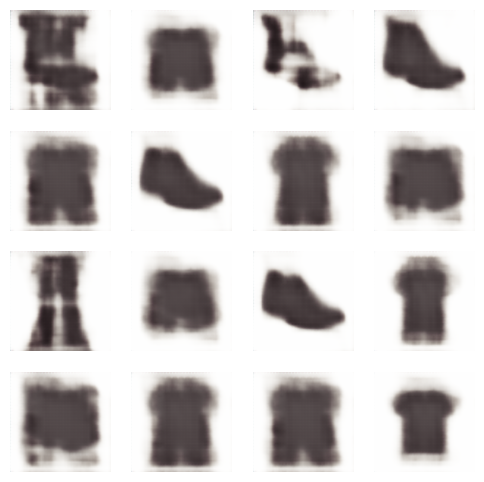

In [ ]:
z_samples = np.random.normal(size=(16, 2)).astype("float32")

generated = decoder_base_2d.predict(z_samples)

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(generated[i])
    plt.axis("off")
plt.show()

## <font color= #66b0b0>• **Simple model architecture - MSE - dim(64)** </font>

In [ ]:
# Build default 64 encoder
encoder_base = build_encoder()
encoder_base.summary()

# Build default 64 decoder
decoder_base = build_decoder()
decoder_base.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │        896 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     18,496 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    204,928 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │    819,456 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32768)     │          0 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │  2,097,216 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │  2,097,216 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 64)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,418,368 (24.48 MB)

 Trainable params: 6,418,368 (24.48 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_latent (InputLayer)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32768)          │     2,129,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 16, 16, 256)    │     3,277,056 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 32, 128)    │       819,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 256, 256, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,319,427 (24.11 MB)

 Trainable params: 6,319,427 (24.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Initiate VAE Model and compile
vae_base1 = VAE_MSEM_KL(encoder_base, decoder_base)
vae_base1.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

vae_base1.build((None, 256, 256, 3))
vae_base1.summary()

Model: "vae_msem_kl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 64), (None,    │     6,418,368 │
│                                 │ 64), (None, 64))       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 256, 256, 3)    │     6,319,427 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,737,795 (48.59 MB)

 Trainable params: 12,737,795 (48.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_base_1 = vae_base1.fit(x_train, epochs=35, batch_size=16, shuffle=True, validation_split=0.1)

Epoch 1/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - elbo: 29400.0703 - kl: 336.6630 - mse: 29063.4082 - val_val-elbo: 8338.2305 - val_val-kl: 189.1561 - val_val-mse: 8149.0747
Epoch 2/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - elbo: 7475.4932 - kl: 177.0599 - mse: 7298.4321 - val_val-elbo: 5758.6992 - val_val-kl: 116.2895 - val_val-mse: 5642.4097
Epoch 3/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - elbo: 5713.4277 - kl: 111.8632 - mse: 5601.5649 - val_val-elbo: 5254.5337 - val_val-kl: 116.6369 - val_val-mse: 5137.8955
Epoch 4/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - elbo: 5089.9438 - kl: 107.6849 - mse: 4982.2603 - val_val-elbo: 4552.9131 - val_val-kl: 124.0378 - val_val-mse: 4428.8760
Epoch 5/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - elbo: 4278.5327 - kl: 122.1687 - mse: 4156.3638 - val_val-elbo: 3784.0776 - val_val-kl: 124.2989 - val_val-mse: 3659.7788
Epoch 6/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - elbo: 3579.4827 - kl: 128.3948 - mse: 3451.0876 - val_va

In [ ]:
encoder_base.save("/content/drive/MyDrive/processed/Models/encoder_base_mse_1.keras")
decoder_base.save("/content/drive/MyDrive/processed/Models/decoder_base_mse_1.keras")

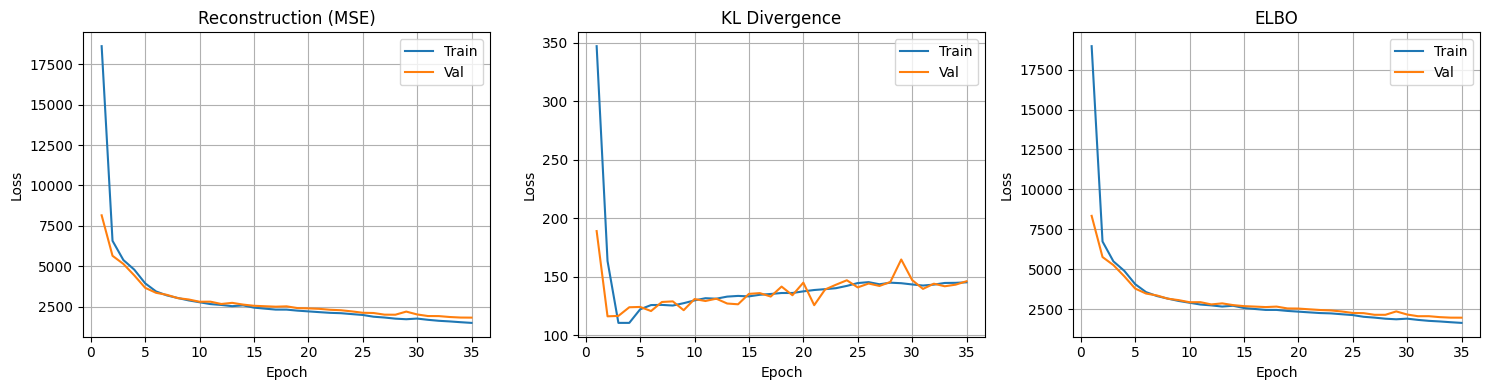

In [ ]:
epochs = range(1, len(history_base_1.history["elbo"]) + 1)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Let's plot our MSE
axes[0].plot(epochs, history_base_1.history["mse"], label="Train")
axes[0].plot(epochs, history_base_1.history["val_val-mse"], label="Val")
axes[0].set_title("Reconstruction (MSE)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# Then we plot our KL
axes[1].plot(epochs, history_base_1.history["kl"], label="Train")
axes[1].plot(epochs, history_base_1.history["val_val-kl"], label="Val")
axes[1].set_title("KL Divergence")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

# And finally the ELBO [MSE + KL]
axes[2].plot(epochs, history_base_1.history["elbo"], label="Train")
axes[2].plot(epochs, history_base_1.history["val_val-elbo"], label="Val")
axes[2].set_title("ELBO")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


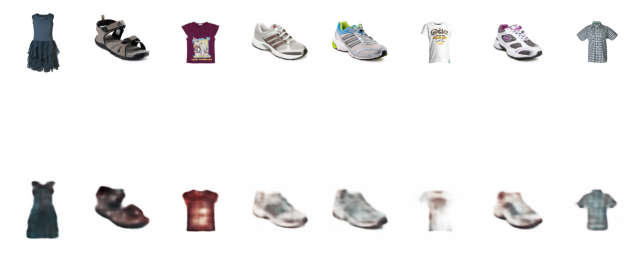

In [ ]:
recon_base_1 = vae_base1.predict(x_test[:8])

plt.figure(figsize=(8,4))
for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(x_test[i])
    plt.axis("off")

    plt.subplot(2,8,i+9)
    plt.imshow(recon_base_1[i])
    plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


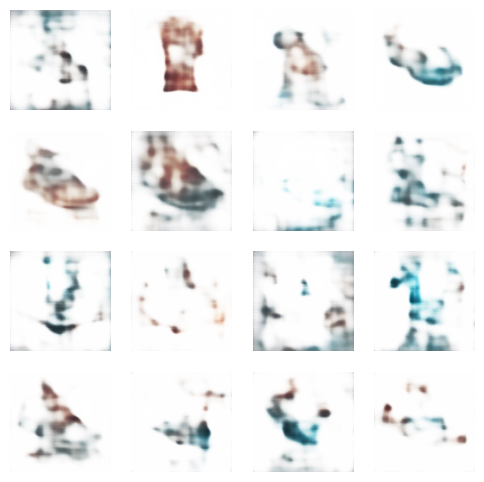

In [ ]:
z_samples = np.random.normal(size=(16, 64)).astype("float32")

generated = decoder_base.predict(z_samples)

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(generated[i])
    plt.axis("off")
plt.show()

## <font color= #66b0b0>• **Simple model architecture - MSE - dim(128)** </font>

In [ ]:
# Build dim = 128 encoder
encoder_base_128 = build_encoder(latent_dim=128)
encoder_base_128.summary()

# Build dim = 128 decoder
decoder_base_128 = build_decoder(latent_dim=128)
decoder_base_128.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │        896 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 64, 64,    │     18,496 │ conv2d_10[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 32,    │    204,928 │ conv2d_11[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 16, 16,    │    819,456 │ conv2d_12[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 8, 8, 512) │  1,180,160 │ conv2d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 32768)     │          0 │ conv2d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 128)       │  4,194,432 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 128)       │  4,194,432 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 128)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,612,800 (40.48 MB)

 Trainable params: 10,612,800 (40.48 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_latent (InputLayer)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32768)          │     4,227,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 16, 16, 256)    │     3,277,056 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 32, 32, 128)    │       819,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_14             │ (None, 256, 256, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,416,579 (32.11 MB)

 Trainable params: 8,416,579 (32.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Initiate VAE Model and compile
vae_base2 = VAE_MSEM_KL(encoder_base_128, decoder_base_128)
vae_base2.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

vae_base2.build((None, 256, 256, 3))
vae_base2.summary()

Model: "vae_msem_kl_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 128), (None,   │    10,612,800 │
│                                 │ 128), (None, 128))     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 256, 256, 3)    │     8,416,579 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,029,379 (72.59 MB)

 Trainable params: 19,029,379 (72.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_base_2 = vae_base2.fit(x_train, epochs=35, batch_size=16, shuffle=True, validation_split=0.1)

Epoch 1/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 23s 114ms/step - elbo: 25663.0938 - kl: 380.5423 - mse: 25282.5508 - val_val-elbo: 7587.6094 - val_val-kl: 274.2932 - val_val-mse: 7313.3154
Epoch 2/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - elbo: 6709.1660 - kl: 198.3391 - mse: 6510.8276 - val_val-elbo: 5618.7852 - val_val-kl: 155.4478 - val_val-mse: 5463.3374
Epoch 3/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - elbo: 5505.9229 - kl: 130.1061 - mse: 5375.8169 - val_val-elbo: 5073.2710 - val_val-kl: 126.0621 - val_val-mse: 4947.2085
Epoch 4/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - elbo: 4927.6455 - kl: 121.4856 - mse: 4806.1597 - val_val-elbo: 4513.2954 - val_val-kl: 119.6990 - val_val-mse: 4393.5967
Epoch 5/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - elbo: 4349.5654 - kl: 136.5202 - mse: 4213.0454 - val_val-elbo: 3846.7461 - val_val-kl: 150.8320 - val_val-mse: 3695.9141
Epoch 6/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - elbo: 3662.1306 - kl: 148.6422 - mse: 3513.4888 - val_va

In [ ]:
encoder_base_128.save("/content/drive/MyDrive/processed/Models/encoder_base_mse_2.keras")
decoder_base_128.save("/content/drive/MyDrive/processed/Models/decoder_base_mse_2.keras")

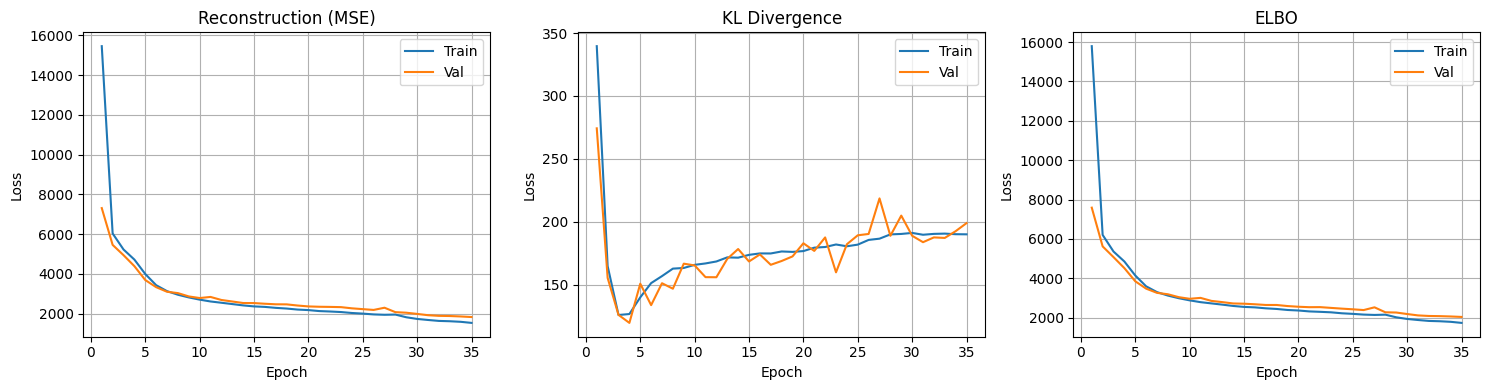

In [ ]:
epochs = range(1, len(history_base_2.history["elbo"]) + 1)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Let's plot our MSE
axes[0].plot(epochs, history_base_2.history["mse"], label="Train")
axes[0].plot(epochs, history_base_2.history["val_val-mse"], label="Val")
axes[0].set_title("Reconstruction (MSE)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# Then we plot our KL
axes[1].plot(epochs, history_base_2.history["kl"], label="Train")
axes[1].plot(epochs, history_base_2.history["val_val-kl"], label="Val")
axes[1].set_title("KL Divergence")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

# And finally the ELBO [MSE + KL]
axes[2].plot(epochs, history_base_2.history["elbo"], label="Train")
axes[2].plot(epochs, history_base_2.history["val_val-elbo"], label="Val")
axes[2].set_title("ELBO")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


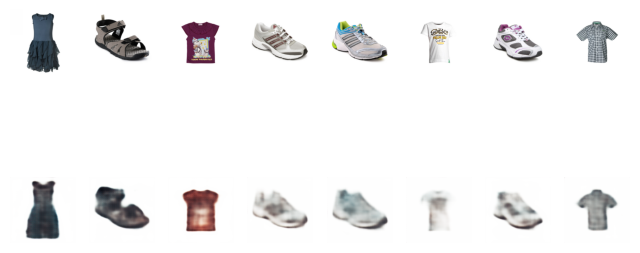

In [ ]:
recon_base_2 = vae_base2.predict(x_test[:8])

plt.figure(figsize=(8,4))
for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(x_test[i])
    plt.axis("off")

    plt.subplot(2,8,i+9)
    plt.imshow(recon_base_2[i])
    plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


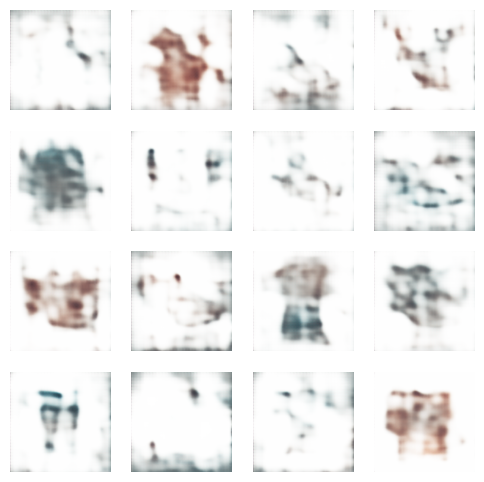

In [ ]:
z_samples = np.random.normal(size=(16, 128)).astype("float32")

generated = decoder_base_128.predict(z_samples)

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(generated[i])
    plt.axis("off")
plt.show()

## <font color= #66b0b0>• **Compute SSIM** </font>
The **Structural Similarity Index Measure (SSIM)** evaluates how similar a reconstructed image is to the original by comparing their **structural information**, rather than just pixel-wise errors. It measures similarity in terms of luminance (brightness), contrast, and structure, which makes it much closer to **how humans perceive** image quality. 

In the context of VAEs, SSIM helps assess whether the model preserves important visual patterns such as edges, shapes, and textures, even if small pixel-level differences exist. A higher SSIM value indicates that the reconstruction maintains the overall structure and visual coherence of the original image, making it a useful complementary metric to reconstruction losses like MSE or MAE, which do not capture perceptual quality as effectively.

In [ ]:
from skimage.metrics import structural_similarity as ssim

def compute_ssim_batch(x_true, x_recon):
    """
    Compute average SSIM for batches of images (Tensor or np.array).
    """
    # Size of the images passed
    batch_size = x_true.shape[0]

    # store the SSIM for each image
    ssim_scores = []

    # Convert to numpy if TF tensor
    if isinstance(x_true, tf.Tensor):
        x_true = x_true.numpy()
    if isinstance(x_recon, tf.Tensor):
        x_recon = x_recon.numpy()

    # Loop for all images in the test
    for i in range(batch_size):
        img_true = x_true[i]
        img_recon = x_recon[i]

        # Sim Index 1 = the same
        score = ssim(
            img_true,
            img_recon,
            channel_axis=2,            # color channels
            data_range=img_true.max() - img_true.min(),
            win_size=7 # Size of window/filter
        )
        ssim_scores.append(score)

    return np.mean(ssim_scores)

z_mean, _, _ = vae_base1.encoder(x_test[:32])
x_recon_64 = vae_base1.decoder(z_mean)

z_mean, _, _ = vae_base2.encoder(x_test[:32])
x_recon_128 = vae_base2.decoder(z_mean)

ssim_64 = compute_ssim_batch(x_test[:32], x_recon_64)
ssim_128 = compute_ssim_batch(x_test[:32], x_recon_128)

print("SSIM dim=64:", ssim_64)
print("SSIM dim=128:", ssim_128)

SSIM dim=64: 0.79303217
SSIM dim=128: 0.7914504


In [ ]:
z_mean, _, _ = vae_base_2d.encoder(x_test[:32])
x_recon_2d = vae_base_2d.decoder(z_mean)

ssim_2d = compute_ssim_batch(x_test[:32], x_recon_2d)

print("SSIM dim=2d:", ssim_2d)

SSIM dim=2d: 0.7429247


With a very small latent space (e.g., 2D), the VAE is forced to compress the image extremely aggressively, which causes color and fine texture information to be averaged out, often producing grayscale reconstructions. However, this strong bottleneck encourages the model to preserve global structure and edges, which are the aspects most strongly rewarded by SSIM. In contrast, a larger latent space (e.g., 64D) can encode color and texture information, but KL regularization spreads information across many noisy dimensions, which can slightly degrade edge sharpness and shape consistency. Because SSIM emphasizes structural similarity over color accuracy, both models can achieve similar SSIM scores despite producing visually very different reconstructions.

## <font color= #66b0b0>• **Simple model architecture - MAE - 2D** </font>

In [10]:
# Build encoder dim=2d
encoder_base_mae_2d = build_encoder(latent_dim=2)
encoder_base_mae_2d.summary()

# Build decoder dim=2d
decoder_base_mae_2d = build_decoder(latent_dim=2)
decoder_base_mae_2d.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    204,928 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │    819,456 │ conv2d_2[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32768)     │          0 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │     65,538 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │     65,538 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,355,012 (8.98 MB)

 Trainable params: 2,355,012 (8.98 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_latent (InputLayer)       │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32768)          │        98,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     3,277,056 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       819,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 256, 256, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,811 (16.36 MB)

 Trainable params: 4,287,811 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Initiate VAE Model and compile
vae_base_mae_2d = VAE_MAE_KL(encoder_base_mae_2d, decoder_base_mae_2d, beta=1)
vae_base_mae_2d.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

vae_base_mae_2d.build((None, 256, 256, 3))
vae_base_mae_2d.summary()

Model: "vae_mae_kl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 2), (None, 2), │     2,355,012 │
│                                 │ (None, 2))             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 256, 256, 3)    │     4,287,811 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,642,823 (25.34 MB)

 Trainable params: 6,642,823 (25.34 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history_base_mae_2d = vae_base_mae_2d.fit(x_train, epochs=35, batch_size=16, shuffle=True, validation_split=0.1)

Epoch 1/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 147ms/step - elbo: 64711.1367 - kl: 1547.6227 - mae: 63163.5117 - val_elbo: 23604.3867 - val_kl: 113.0625 - val_mae: 23491.3262
Epoch 2/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - elbo: 22387.8613 - kl: 121.0239 - mae: 22266.8398 - val_elbo: 19826.8184 - val_kl: 130.5346 - val_mae: 19696.2852
Epoch 3/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - elbo: 19469.3652 - kl: 144.3521 - mae: 19325.0137 - val_elbo: 18442.2129 - val_kl: 94.3883 - val_mae: 18347.8223
Epoch 4/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - elbo: 18221.0664 - kl: 103.3404 - mae: 18117.7227 - val_elbo: 17546.2695 - val_kl: 59.7625 - val_mae: 17486.5039
Epoch 5/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - elbo: 16741.9355 - kl: 66.1306 - mae: 16675.8027 - val_elbo: 15687.5820 - val_kl: 63.5440 - val_mae: 15624.0400
Epoch 6/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - elbo: 15709.1221 - kl: 50.8839 - mae: 15658.2402 - val_elbo: 14938.9346 - val_kl: 42.2721 - val_mae:

In [18]:
encoder_base_mae_2d.save("/content/drive/MyDrive/processed/Models/encoder_base_mae_2d.keras")
decoder_base_mae_2d.save("/content/drive/MyDrive/processed/Models/decoder_base_mae_2d.keras")

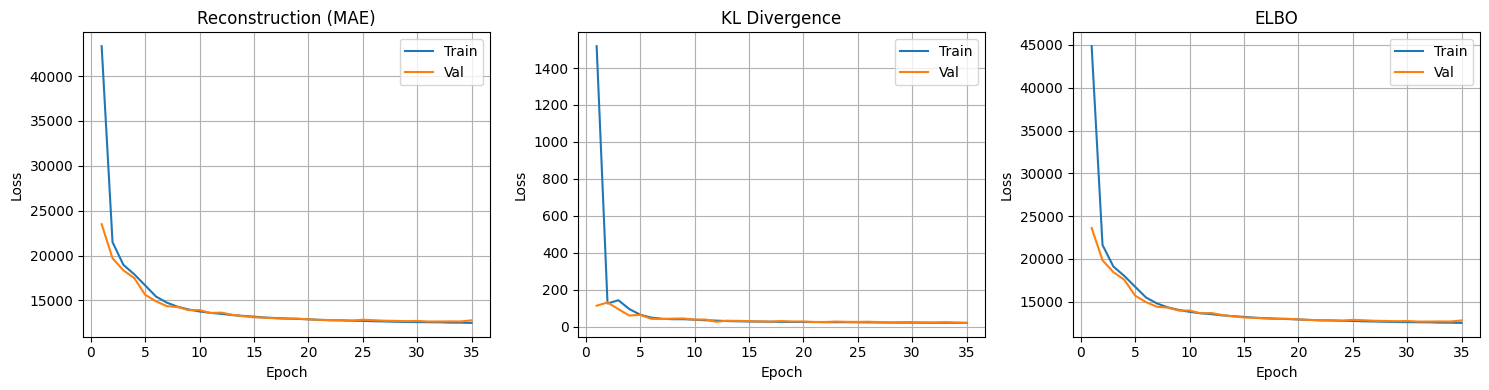

In [13]:
epochs = range(1, len(history_base_mae_2d.history["elbo"]) + 1)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Let's plot our MAE
axes[0].plot(epochs, history_base_mae_2d.history["mae"], label="Train")
axes[0].plot(epochs, history_base_mae_2d.history["val_mae"], label="Val")
axes[0].set_title("Reconstruction (MAE)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# Then we plot our KL
axes[1].plot(epochs, history_base_mae_2d.history["kl"], label="Train")
axes[1].plot(epochs, history_base_mae_2d.history["val_kl"], label="Val")
axes[1].set_title("KL Divergence")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

# And finally the ELBO [MAE + KL]
axes[2].plot(epochs, history_base_mae_2d.history["elbo"], label="Train")
axes[2].plot(epochs, history_base_mae_2d.history["val_elbo"], label="Val")
axes[2].set_title("ELBO")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


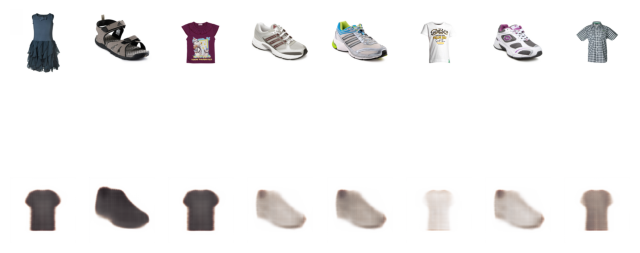

In [14]:
recon_base_mae_2d = vae_base_mae_2d.predict(x_test[:8])

plt.figure(figsize=(8,4))
for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(x_test[i])
    plt.axis("off")

    plt.subplot(2,8,i+9)
    plt.imshow(recon_base_mae_2d[i])
    plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


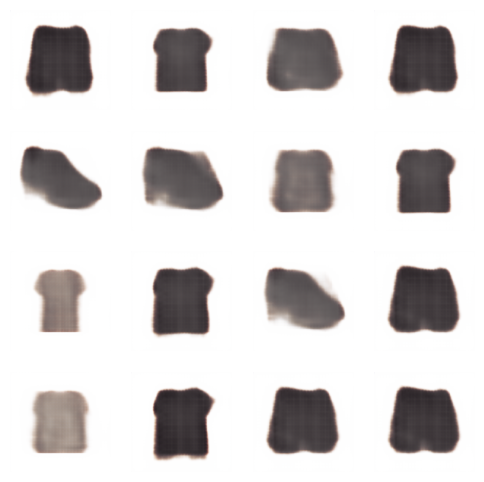

In [17]:
z_samples = np.random.normal(size=(16, 2)).astype("float32")

generated = decoder_base_mae_2d.predict(z_samples)

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(generated[i])
    plt.axis("off")
plt.show()

## <font color= #66b0b0>• **Simple model architecture - MAE - dim(64)** </font>

In [ ]:
# Build default 64 encoder
encoder_base_mae_64 = build_encoder()
encoder_base_mae_64.summary()

# Build default 64 decoder
decoder_base_mae_64 = build_decoder()
decoder_base_mae_64.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │        896 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     18,496 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    204,928 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │    819,456 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32768)     │          0 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │  2,097,216 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │  2,097,216 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 64)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,418,368 (24.48 MB)

 Trainable params: 6,418,368 (24.48 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_latent (InputLayer)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32768)          │     2,129,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 16, 16, 256)    │     3,277,056 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 32, 128)    │       819,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 256, 256, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,319,427 (24.11 MB)

 Trainable params: 6,319,427 (24.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Initiate VAE Model and compile
vae_base_mae = VAE_MAE_KL(encoder_base_mae_64, decoder_base_mae_64, beta=3)
vae_base_mae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

vae_base_mae.build((None, 256, 256, 3))
vae_base_mae.summary()

Model: "vae_mae_kl_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 64), (None,    │     6,418,368 │
│                                 │ 64), (None, 64))       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 256, 256, 3)    │     6,319,427 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,737,795 (48.59 MB)

 Trainable params: 12,737,795 (48.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_base_mae = vae_base_mae.fit(x_train, epochs=35, batch_size=16, shuffle=True, validation_split=0.1)

Epoch 1/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - elbo: 62380.5039 - kl: 326.6898 - mae: 61400.4258 - val_elbo: 21346.9668 - val_kl: 138.9469 - val_mae: 20930.1250
Epoch 2/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - elbo: 20809.5645 - kl: 114.0191 - mae: 20467.5098 - val_elbo: 17348.3906 - val_kl: 108.7028 - val_mae: 17022.2812
Epoch 3/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - elbo: 17193.4141 - kl: 84.8237 - mae: 16938.9453 - val_elbo: 15526.6406 - val_kl: 92.1716 - val_mae: 15250.1260
Epoch 4/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - elbo: 15092.4131 - kl: 92.5444 - mae: 14814.7812 - val_elbo: 13612.5322 - val_kl: 98.1825 - val_mae: 13317.9854
Epoch 5/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - elbo: 13362.0449 - kl: 109.1601 - mae: 13034.5674 - val_elbo: 12411.5371 - val_kl: 97.3591 - val_mae: 12119.4619
Epoch 6/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - elbo: 12086.5352 - kl: 116.0768 - mae: 11738.3047 - val_elbo: 11674.7031 - val_kl: 109.4558 - val_mae:

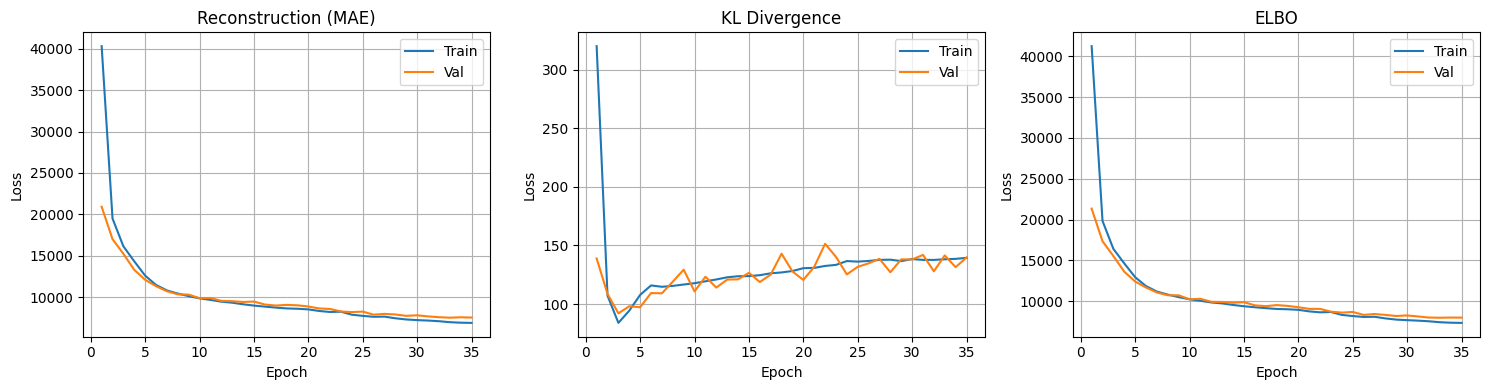

In [ ]:
epochs = range(1, len(history_base_mae.history["elbo"]) + 1)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Let's plot our MSE
axes[0].plot(epochs, history_base_mae.history["mae"], label="Train")
axes[0].plot(epochs, history_base_mae.history["val_mae"], label="Val")
axes[0].set_title("Reconstruction (MAE)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# Then we plot our KL
axes[1].plot(epochs, history_base_mae.history["kl"], label="Train")
axes[1].plot(epochs, history_base_mae.history["val_kl"], label="Val")
axes[1].set_title("KL Divergence")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

# And finally the ELBO [MAE + KL]
axes[2].plot(epochs, history_base_mae.history["elbo"], label="Train")
axes[2].plot(epochs, history_base_mae.history["val_elbo"], label="Val")
axes[2].set_title("ELBO")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


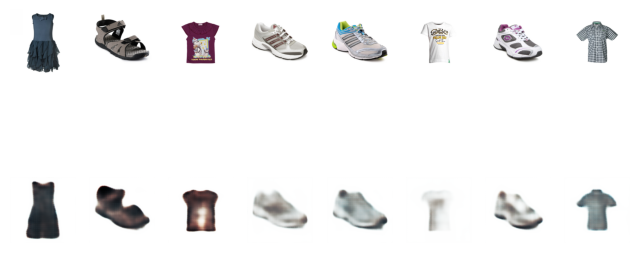

In [ ]:
recon_base_mae = vae_base_mae.predict(x_test[:8])

plt.figure(figsize=(8,4))
for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(x_test[i])
    plt.axis("off")

    plt.subplot(2,8,i+9)
    plt.imshow(recon_base_mae[i])
    plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


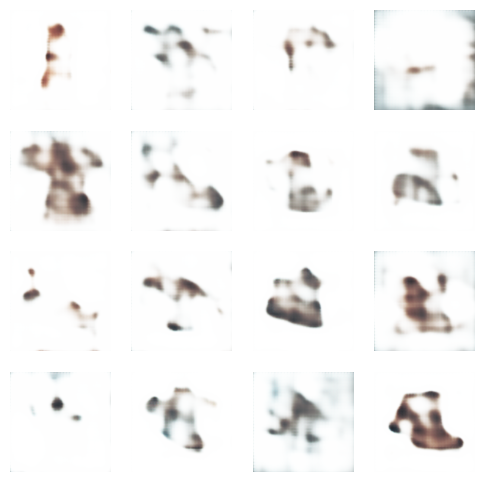

In [ ]:
z_samples = np.random.normal(size=(16, 64)).astype("float32")

generated = decoder_base_mae_64.predict(z_samples)

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(generated[i])
    plt.axis("off")
plt.show()

## <font color= #66b0b0>• **Simple model architecture - MAE - dim(128)** </font>

In [ ]:
# Build dim = 128 encoder
encoder_base_mae_128 = build_encoder(latent_dim=128)
encoder_base_mae_128.summary()

# Build dim = 128 decoder
decoder_base_mae_128 = build_decoder(latent_dim=128)
decoder_base_mae_128.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    204,928 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │    819,456 │ conv2d_2[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32768)     │          0 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 128)       │  4,194,432 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 128)       │  4,194,432 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 128)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,612,800 (40.48 MB)

 Trainable params: 10,612,800 (40.48 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_latent (InputLayer)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32768)          │     4,227,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     3,277,056 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       819,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 256, 256, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,416,579 (32.11 MB)

 Trainable params: 8,416,579 (32.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Initiate VAE Model and compile
vae_base_mae_128 = VAE_MAE_KL(encoder_base_mae_128, decoder_base_mae_128, beta=5)
vae_base_mae_128.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

vae_base_mae_128.build((None, 256, 256, 3))
vae_base_mae_128.summary()

Model: "vae_mae_kl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 128), (None,   │    10,612,800 │
│                                 │ 128), (None, 128))     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 256, 256, 3)    │     8,416,579 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,029,379 (72.59 MB)

 Trainable params: 19,029,379 (72.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_base_mae_128_2 = vae_base_mae_128.fit(x_train, epochs=35, batch_size=16, shuffle=True, validation_split=0.1)

Epoch 1/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 158ms/step - elbo: 58975.1797 - kl: 211.3740 - mae: 57918.3008 - val_elbo: 20851.1465 - val_kl: 93.8111 - val_mae: 20382.0918
Epoch 2/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - elbo: 20153.0742 - kl: 78.6789 - mae: 19759.6816 - val_elbo: 17064.3340 - val_kl: 81.5409 - val_mae: 16656.6289
Epoch 3/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - elbo: 16929.4473 - kl: 64.3681 - mae: 16607.6074 - val_elbo: 15666.1523 - val_kl: 62.1638 - val_mae: 15355.3301
Epoch 4/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - elbo: 15868.0967 - kl: 69.2562 - mae: 15521.8135 - val_elbo: 14752.0654 - val_kl: 72.9207 - val_mae: 14387.4600
Epoch 5/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - elbo: 14657.6367 - kl: 73.7056 - mae: 14289.1113 - val_elbo: 13201.3252 - val_kl: 89.1610 - val_mae: 12755.5186
Epoch 6/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - elbo: 12821.4600 - kl: 92.1959 - mae: 12360.4795 - val_elbo: 12301.8281 - val_kl: 116.0442 - val_mae: 11721

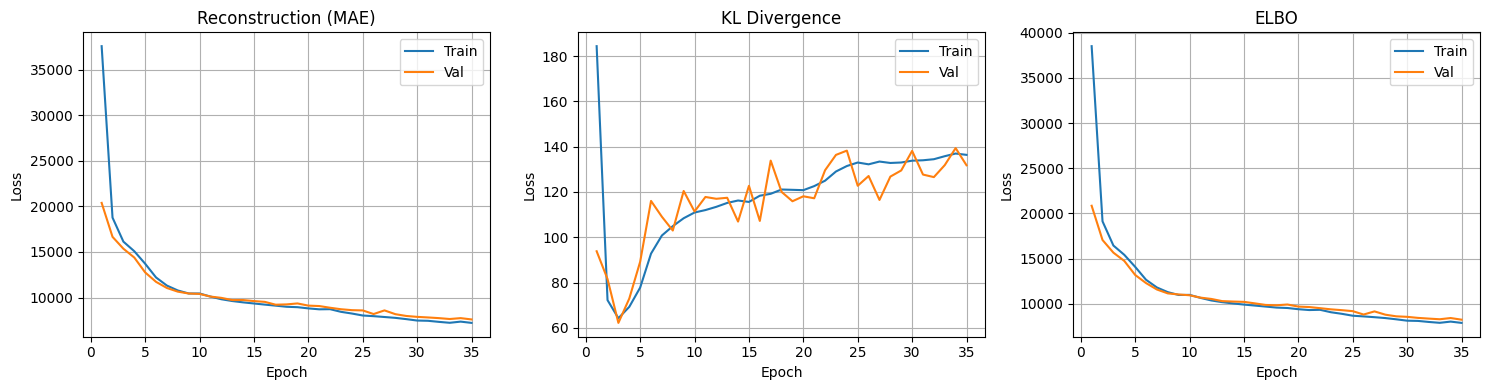

In [ ]:
epochs = range(1, len(vae_base_mae_128.history["elbo"]) + 1)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Let's plot our MSE
axes[0].plot(epochs, vae_base_mae_128.history["mae"], label="Train")
axes[0].plot(epochs, vae_base_mae_128.history["val_mae"], label="Val")
axes[0].set_title("Reconstruction (MAE)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# Then we plot our KL
axes[1].plot(epochs, vae_base_mae_128.history["kl"], label="Train")
axes[1].plot(epochs, vae_base_mae_128.history["val_kl"], label="Val")
axes[1].set_title("KL Divergence")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

# And finally the ELBO [MAE + KL]
axes[2].plot(epochs, vae_base_mae_128.history["elbo"], label="Train")
axes[2].plot(epochs, vae_base_mae_128.history["val_elbo"], label="Val")
axes[2].set_title("ELBO")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


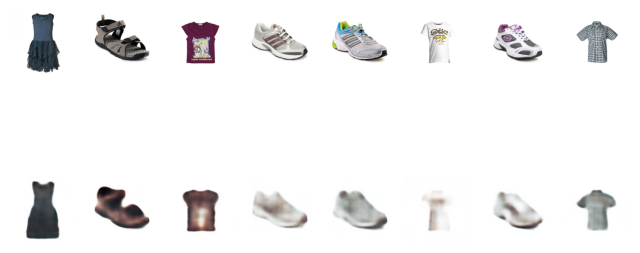

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


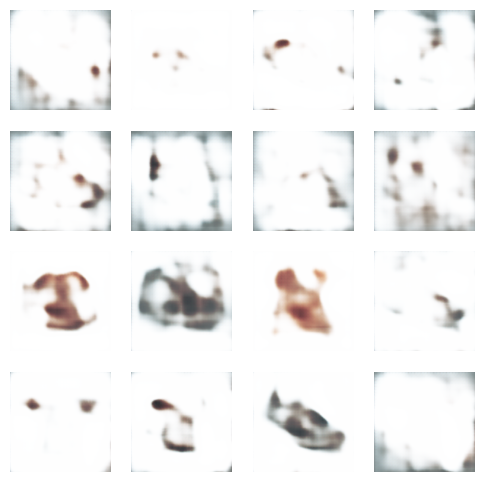

In [ ]:
recon_base_mae_128 = vae_base_mae_128.predict(x_test[:8])

plt.figure(figsize=(8,4))
for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(x_test[i])
    plt.axis("off")

    plt.subplot(2,8,i+9)
    plt.imshow(recon_base_mae_128[i])
    plt.axis("off")
plt.show()

z_samples = np.random.normal(size=(16, 128)).astype("float32")

generated = decoder_base_mae_128.predict(z_samples)

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(generated[i])
    plt.axis("off")
plt.show()

In [ ]:
z_mean, _, _ = vae_base_mae.encoder(x_test[:32])
x_recon_64 = vae_base_mae.decoder(z_mean)

z_mean, _, _ = vae_base_mae_128.encoder(x_test[:32])
x_recon_128 = vae_base_mae_128.decoder(z_mean)

ssim_64 = compute_ssim_batch(x_test[:32], x_recon_64)
ssim_128 = compute_ssim_batch(x_test[:32], x_recon_128)

print("SSIM dim=64:", ssim_64)
print("SSIM dim=128:", ssim_128)

SSIM dim=64: 0.7932029
SSIM dim=128: 0.7921459


In [19]:
z_mean, _, _ = vae_base_mae_2d.encoder(x_test[:32])
x_recon_2d = vae_base_mae_2d.decoder(z_mean)

ssim_2d = compute_ssim_batch(x_test[:32], x_recon_2d)

print("SSIM dim=2d:", ssim_2d)

SSIM dim=2d: 0.75417835


These results show that, for the base decoder architecture, MAE and MSE lead to very similar SSIM scores, with MAE being marginally better overall. In both, increasing the latent size to 128 does not improve—and slightly degrades—structural similarity. This suggests that the base model already captures the most relevant structural information with a moderate latent capacity, and that adding more latent dimensions introduces redundancy rather than meaningful detail. 

## <font color= #66b0b0>• **Complex model architecture** </font>
The complex VAE introduces fewer downsampling stages with additional dense layers and batch normalization to improve stability and representation capacity

In [ ]:
def build_encoder2(input_shape=(256, 256, 3), latent_dim=64):
    """
    Encoder function which recieves 2 optional arguments.

    Args:
    input_shape: The input dimension specified for images (pixel, pixel, channels)
    latent_dim: The dimension to which we will reduce our images for the latent space
    """

    encoder_input = Input(shape=input_shape, name="encoder_input")

    # Conv + BN layers
    x = Conv2D(32, 4, strides=2, padding="same", activation="relu")(encoder_input)  # 128x128x32
    x = BatchNormalization()(x)

    x = Conv2D(64, 4, strides=2, padding="same", activation="relu")(x)              # 64x64x64
    x = BatchNormalization()(x)

    x = Conv2D(128, 4, strides=2, padding="same", activation="relu")(x)             # 32x32x128
    x = BatchNormalization()(x)

    x = Conv2D(256, 4, strides=2, padding="same", activation="relu")(x)             # 16x16x256
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(512, activation="relu")(x)

    # Latent space
    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)
    z = Lambda(sampling, name="z")([z_mean, z_log_var])

    encoder = Model(encoder_input, outputs=[z_mean, z_log_var, z], name="encoder")
    return encoder

In [ ]:
def build_decoder2(latent_dim=64):
    """
    Decoder function which recieves 1 optional argument.

    Args:
    input_shape/latent_dim: Since we are sampling from the latent_dim, out input will be a vector of that size.
    """

    decoder_input = Input(shape=(latent_dim,), name="decoder_input")

    x = Dense(16 * 16 * 256, activation="relu")(decoder_input)
    x = Reshape((16, 16, 256))(x)

    x = Conv2DTranspose(128, 4, strides=2, padding="same", activation="relu")(x)
    x = Conv2DTranspose(64, 4, strides=2, padding="same", activation="relu")(x)
    x = Conv2DTranspose(32, 4, strides=2, padding="same", activation="relu")(x)

    decoder_output = Conv2DTranspose(3, 4, strides=2, padding="same", activation="sigmoid")(x)

    decoder = Model(decoder_input, decoder_output, name="decoder")
    return decoder


## <font color= #66b0b0>• **Complex model architecture - MSE - dim(128)** </font>

In [ ]:
# Build encoder dim=128
encoder_mse_complex_128 = build_encoder2(latent_dim=128)
encoder_mse_complex_128.summary()

# Build decoder dim=128
decoder_mse_complex_128 = build_decoder2(latent_dim=128)
decoder_mse_complex_128.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │      1,568 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │     32,832 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │    131,200 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 16, 16,    │    524,544 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 65536)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │ 33,554,944 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 128)       │     65,664 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 128)       │     65,664 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 128)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,378,336 (131.14 MB)

 Trainable params: 34,377,376 (131.14 MB)

 Non-trainable params: 960 (3.75 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 65536)          │     8,454,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 32, 32, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 64, 64, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 128, 128, 32)   │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 256, 256, 3)    │         1,539 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,144,035 (34.88 MB)

 Trainable params: 9,144,035 (34.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Initiate VAE Model and compile
vae_mse_complex_128 = VAE_MSEM_KL(encoder_mse_complex_128, decoder_mse_complex_128)
vae_mse_complex_128.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

vae_mse_complex_128.build((None, 256, 256, 3))
vae_mse_complex_128.summary()

Model: "vae_msem_kl_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 128), (None,   │    34,378,336 │
│                                 │ 128), (None, 128))     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 256, 256, 3)    │     9,144,035 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,522,371 (166.02 MB)

 Trainable params: 43,521,411 (166.02 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
history_mse_complex_128 = vae_mse_complex_128.fit(x_train,epochs=35,batch_size=16,shuffle=True,validation_split=0.1)

Epoch 1/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 142ms/step - elbo: 28171.1699 - kl: 418.1923 - mse: 27752.9766 - val_val-elbo: 9945.7568 - val_val-kl: 22.7777 - val_val-mse: 9922.9785
Epoch 2/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - elbo: 5771.4126 - kl: 279.6266 - mse: 5491.7861 - val_val-elbo: 6815.6279 - val_val-kl: 34.1042 - val_val-mse: 6781.5244
Epoch 3/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - elbo: 4923.8770 - kl: 228.5488 - mse: 4695.3286 - val_val-elbo: 6503.3052 - val_val-kl: 67.1059 - val_val-mse: 6436.1992
Epoch 4/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - elbo: 4717.0923 - kl: 220.2837 - mse: 4496.8081 - val_val-elbo: 4839.5342 - val_val-kl: 147.7348 - val_val-mse: 4691.7993
Epoch 5/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - elbo: 4411.7344 - kl: 211.6320 - mse: 4200.1021 - val_val-elbo: 4299.7432 - val_val-kl: 219.1858 - val_val-mse: 4080.5576
Epoch 6/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - elbo: 4095.9236 - kl: 223.3557 - mse: 3872.5676 - val_val-e

In [ ]:
encoder_mse_complex_128.save("/content/drive/MyDrive/processed/Models/encoder_mse_complex_128.keras")
decoder_mse_complex_128.save("/content/drive/MyDrive/processed/Models/decoder_mse_complex_128.keras")

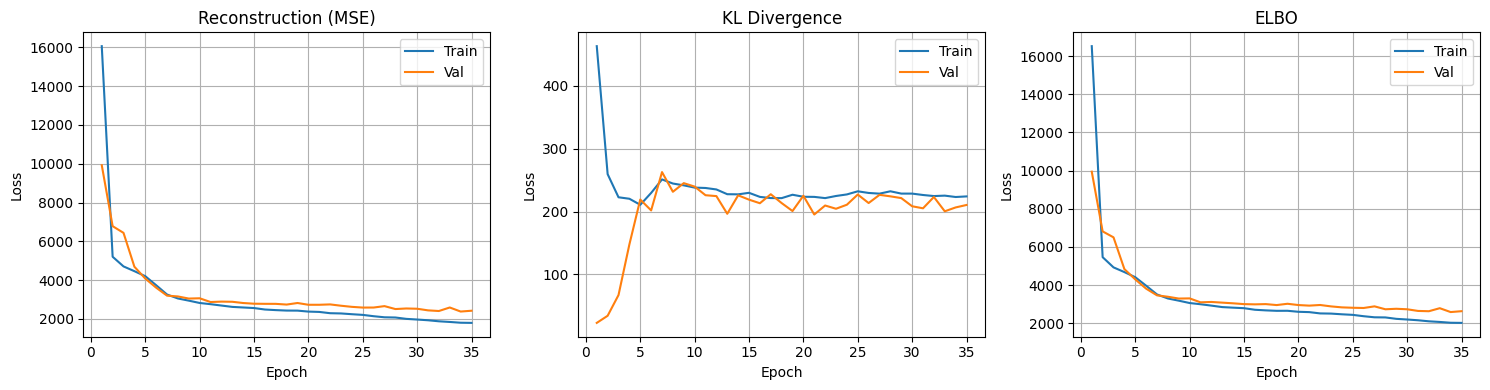

In [ ]:
epochs = range(1, len(history_mse_complex_128.history["elbo"]) + 1)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Let's plot our MSE
axes[0].plot(epochs, history_mse_complex_128.history["mse"], label="Train")
axes[0].plot(epochs, history_mse_complex_128.history["val_val-mse"], label="Val")
axes[0].set_title("Reconstruction (MSE)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# Then we plot our KL
axes[1].plot(epochs, history_mse_complex_128.history["kl"], label="Train")
axes[1].plot(epochs, history_mse_complex_128.history["val_val-kl"], label="Val")
axes[1].set_title("KL Divergence")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

# And finally the ELBO [MSE + KL]
axes[2].plot(epochs, history_mse_complex_128.history["elbo"], label="Train")
axes[2].plot(epochs, history_mse_complex_128.history["val_val-elbo"], label="Val")
axes[2].set_title("ELBO")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


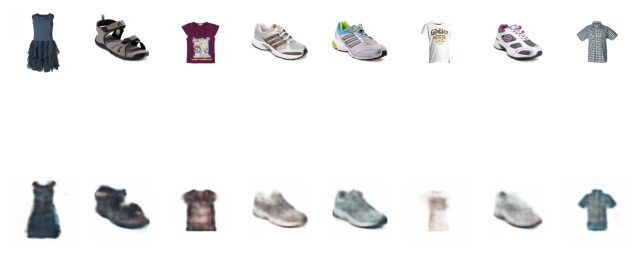

In [ ]:
recon_complex_mse_128 = vae_mse_complex_128.predict(x_test[:8])

plt.figure(figsize=(8,4))
for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(x_test[i])
    plt.axis("off")

    plt.subplot(2,8,i+9)
    plt.imshow(recon_complex_mse_128[i])
    plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


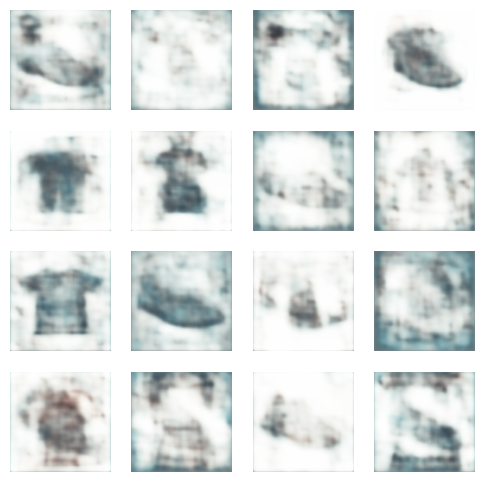

In [ ]:
z_samples = np.random.normal(size=(16, 128)).astype("float32")

generated = decoder_mse_complex_128.predict(z_samples)

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(generated[i])
    plt.axis("off")
plt.show()

## <font color= #66b0b0>• **Complex model architecture - MSE - dim(64)** </font>

In [ ]:
# Build encoder dim=64
encoder_mse_complex_64 = build_encoder2()
encoder_mse_complex_64.summary()

# Build decoder dim=64
decoder_mse_complex_64 = build_decoder2()
decoder_mse_complex_64.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 128, 128,  │      1,568 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │     32,832 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 32, 32,    │    131,200 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 16, 16,    │    524,544 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 65536)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 512)       │ 33,554,944 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │     32,832 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │     32,832 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 64)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,312,672 (130.89 MB)

 Trainable params: 34,311,712 (130.89 MB)

 Non-trainable params: 960 (3.75 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 65536)          │     4,259,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 32, 32, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 64, 64, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_14             │ (None, 128, 128, 32)   │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_15             │ (None, 256, 256, 3)    │         1,539 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,949,731 (18.88 MB)

 Trainable params: 4,949,731 (18.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Initiate VAE Model and compile
vae_mse_complex_64 = VAE_MSEM_KL(encoder_mse_complex_64, decoder_mse_complex_64)
vae_mse_complex_64.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

vae_mse_complex_64.build((None, 256, 256, 3))
vae_mse_complex_64.summary()

Model: "vae_msem_kl_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 64), (None,    │    34,312,672 │
│                                 │ 64), (None, 64))       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 256, 256, 3)    │     4,949,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,262,403 (149.77 MB)

 Trainable params: 39,261,443 (149.77 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
history_mse_complex_64 = vae_mse_complex_64.fit(x_train,epochs=35,batch_size=16,shuffle=True,validation_split=0.1)

Epoch 1/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 26s 113ms/step - elbo: 26048.8535 - kl: 1754.3584 - mse: 24294.4961 - val_val-elbo: 9927.6924 - val_val-kl: 79.5336 - val_val-mse: 9848.1582
Epoch 2/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - elbo: 27869198336.0000 - kl: 27869198336.0000 - mse: 5597.3291 - val_val-elbo: 6039.4487 - val_val-kl: 85.2415 - val_val-mse: 5954.2070
Epoch 3/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - elbo: 21891710.0000 - kl: 21886912.0000 - mse: 4794.4644 - val_val-elbo: 6367.5044 - val_val-kl: 567.0319 - val_val-mse: 5800.4722
Epoch 4/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - elbo: 5377.3589 - kl: 548.6772 - mse: 4828.6802 - val_val-elbo: 5117.6968 - val_val-kl: 258.6027 - val_val-mse: 4859.0942
Epoch 5/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - elbo: 4701.8027 - kl: 265.8943 - mse: 4435.9082 - val_val-elbo: 4631.8398 - val_val-kl: 219.3391 - val_val-mse: 4412.5010
Epoch 6/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - elbo: 4510.6621 - kl: 229.5188 - 

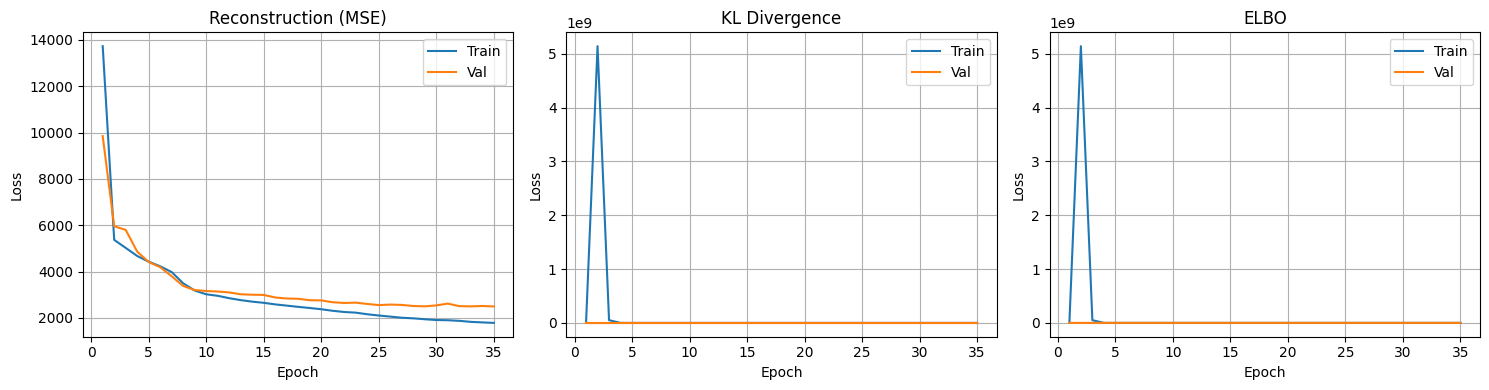

In [ ]:
epochs = range(1, len(history_mse_complex_64.history["elbo"]) + 1)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Let's plot our MSE
axes[0].plot(epochs, history_mse_complex_64.history["mse"], label="Train")
axes[0].plot(epochs, history_mse_complex_64.history["val_val-mse"], label="Val")
axes[0].set_title("Reconstruction (MSE)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# Then we plot our KL
axes[1].plot(epochs, history_mse_complex_64.history["kl"], label="Train")
axes[1].plot(epochs, history_mse_complex_64.history["val_val-kl"], label="Val")
axes[1].set_title("KL Divergence")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

# And finally the ELBO [MSE + KL]
axes[2].plot(epochs, history_mse_complex_64.history["elbo"], label="Train")
axes[2].plot(epochs, history_mse_complex_64.history["val_val-elbo"], label="Val")
axes[2].set_title("ELBO")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
encoder_mse_complex_64.save("/content/drive/MyDrive/processed/Models/encoder_mse_complex_64.keras")
decoder_mse_complex_64.save("/content/drive/MyDrive/processed/Models/decoder_mse_complex_64.keras")

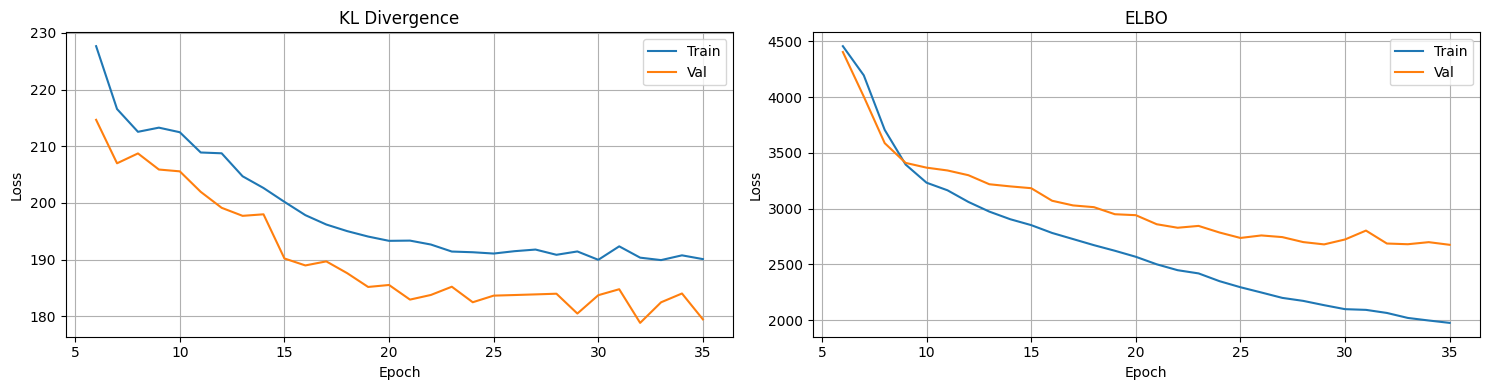

In [ ]:
start_epoch = 5

kl_train = history_mse_complex_64.history["kl"][start_epoch:]
kl_val   = history_mse_complex_64.history["val_val-kl"][start_epoch:]

elbo_train = history_mse_complex_64.history["elbo"][start_epoch:]
elbo_val   = history_mse_complex_64.history["val_val-elbo"][start_epoch:]

epochs = range(start_epoch + 1, start_epoch + 1 + len(kl_train))

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# KL Divergence
axes[0].plot(epochs, kl_train, label="Train")
axes[0].plot(epochs, kl_val, label="Val")
axes[0].set_title("KL Divergence")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# ELBO
axes[1].plot(epochs, elbo_train, label="Train")
axes[1].plot(epochs, elbo_val, label="Val")
axes[1].set_title("ELBO")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


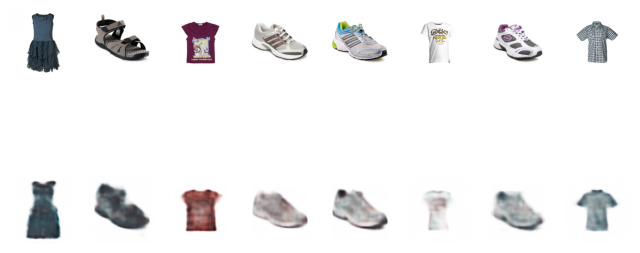

In [ ]:
recon_mse_complex_64 = vae_mse_complex_64.predict(x_test[:8])

plt.figure(figsize=(8,4))
for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(x_test[i])
    plt.axis("off")

    plt.subplot(2,8,i+9)
    plt.imshow(recon_mse_complex_64[i])
    plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


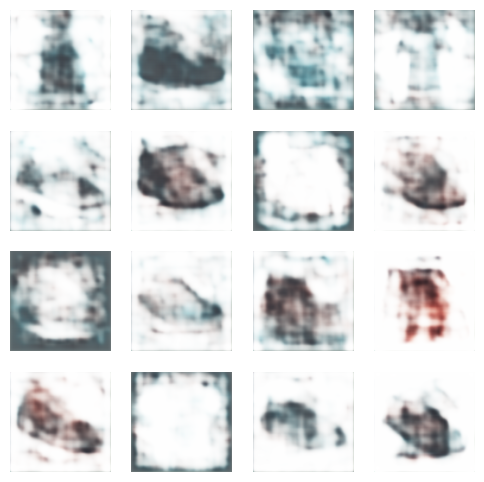

In [ ]:
z_samples = np.random.normal(size=(16, 64)).astype("float32")

generated_2 = decoder_mse_complex_64.predict(z_samples)

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(generated_2[i])
    plt.axis("off")
plt.show()

In [ ]:
z_mean, _, _ = vae_mse_complex_64.encoder(x_test[:32])
x_recon_64 = vae_mse_complex_64.decoder(z_mean)

z_mean, _, _ = vae_mse_complex_128.encoder(x_test[:32])
x_recon_128 = vae_mse_complex_128.decoder(z_mean)

ssim_64 = compute_ssim_batch(x_test[:32], x_recon_64)
ssim_128 = compute_ssim_batch(x_test[:32], x_recon_128)

print("SSIM dim=64:", ssim_64)
print("SSIM dim=128:", ssim_128)

SSIM dim=64: 0.7697135
SSIM dim=128: 0.77208364


These results indicate that increasing architectural complexity and latent dimensionality, while using MSE as the reconstruction loss, did not translate into better perceptual performance. Despite having higher capacity, the complex models achieved relatively low SSIM scores compared to the simpler architecture, suggesting that they struggled to preserve structural details in the reconstructions. Overall, this shows that model simplicity and an appropriate reconstruction loss can be more important than sheer complexity, and that adding depth or parameters does not guarantee improved perceptual quality in VAEs.

# Grayscale images

In [20]:
# Load the grayscale images
X_gray = np.load("/content/drive/MyDrive/processed/X_images_gray.npy")
y_gray = np.load("/content/drive/MyDrive/processed/y_labels_gray.npy")

with open("/content/drive/MyDrive/processed/label_encoder_gray.pkl", "rb") as f:
    le_gray = pickle.load(f)

print(X_gray.shape)
print(y_gray.shape)

(2906, 256, 256, 1)
(2906,)


Training data shapes: X=(2324, 256, 256, 1), y=(2324,)
Testing data shapes: X=(582, 256, 256, 1), y=(582,)


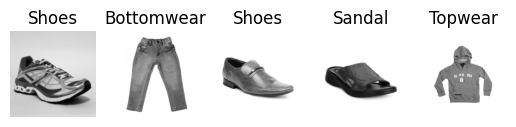

In [22]:
# Split both images and labels together
x_train, x_test, y_train, y_test = train_test_split(X_gray, y_gray, test_size=0.2, random_state=42, stratify=y_gray)  # stratify keeps label distribution

print('Training data shapes: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Testing data shapes: X=%s, y=%s' % (x_test.shape, y_test.shape))

for j in range(5):
    i = np.random.randint(0, x_train.shape[0])
    plt.subplot(1, 5, j+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(le_gray.inverse_transform([y_train[i]])[0])  # <Take first element
    plt.axis('off')
plt.show()

In [32]:
def build_encoder_gray(input_shape=(256, 256, 1), latent_dim=2):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(32, 4, strides=2, padding="same", activation="relu")(inputs)   # 128x128
    x = layers.Conv2D(64, 4, strides=2, padding="same", activation="relu")(x)        # 64x64
    x = layers.Conv2D(128, 4, strides=2, padding="same", activation="relu")(x)       # 32x32
    x = layers.Conv2D(256, 4, strides=2, padding="same", activation="relu")(x)       # 16x16
    x = layers.Conv2D(512, 4, strides=2, padding="same", activation="relu")(x)       # 8x8

    x = layers.Flatten()(x)

    x = layers.Dense(256, activation="relu")(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder_gray(latent_dim=2):
    latent_inputs = Input(shape=(latent_dim,))

    x = layers.Dense(8 * 8 * 512, activation="relu")(latent_inputs)
    x = layers.Reshape((8, 8, 512))(x)

    x = layers.Conv2DTranspose(256, 4, strides=2, padding="same", activation="relu")(x)  # 16x16
    x = layers.Conv2DTranspose(128, 4, strides=2, padding="same", activation="relu")(x)  # 32x32
    x = layers.Conv2DTranspose(64, 4, strides=2, padding="same", activation="relu")(x)   # 64x64
    x = layers.Conv2DTranspose(32, 4, strides=2, padding="same", activation="relu")(x)   # 128x128

    outputs = layers.Conv2DTranspose(
        1, 4, strides=2, padding="same", activation="sigmoid"
    )(x)  # 256x256x1

    return Model(latent_inputs, outputs, name="decoder")

In [33]:
# Build encoder dim=2d
encoder_base_mse_2d_gray = build_encoder_gray()
encoder_base_mse_2d_gray.summary()

# Build decoder dim=2d
decoder_base_mse_2d_gray = build_decoder_gray()
decoder_base_mse_2d_gray.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │        544 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │     32,832 │ conv2d_20[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │    131,200 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 16, 16,    │    524,544 │ conv2d_22[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 8, 8, 512) │  2,097,664 │ conv2d_23[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 32768)     │          0 │ conv2d_24[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │  8,388,864 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        514 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        514 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,176,676 (42.64 MB)

 Trainable params: 11,176,676 (42.64 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32768)          │        98,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_20             │ (None, 16, 16, 256)    │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_21             │ (None, 32, 32, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_22             │ (None, 64, 64, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_23             │ (None, 128, 128, 32)   │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_24             │ (None, 256, 256, 1)    │           513 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,884,577 (11.00 MB)

 Trainable params: 2,884,577 (11.00 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Initiate VAE Model and compile
vae_base_mse_2d_gray = VAE_MSEM_KL(encoder_base_mse_2d_gray, decoder_base_mse_2d_gray)
vae_base_mse_2d_gray.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

vae_base_mse_2d_gray.build((None, 256, 256, 3))
vae_base_mse_2d_gray.summary()

Model: "vae_msem_kl_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 2), (None, 2), │    11,176,676 │
│                                 │ (None, 2))             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 256, 256, 1)    │     2,884,577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,061,253 (53.64 MB)

 Trainable params: 14,061,253 (53.64 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Train our VAE
history_base_mse_2d_gray = vae_base_mse_2d_gray.fit(x_train, epochs=35, batch_size=16, shuffle=True, validation_split=0.1)

Epoch 1/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 27s 130ms/step - elbo: 8982.1758 - kl: 220.7762 - mse: 8761.3984 - val_val-elbo: 2809.8835 - val_val-kl: 2.7673 - val_val-mse: 2807.1162
Epoch 2/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - elbo: 2564.9136 - kl: 11.6163 - mse: 2553.2971 - val_val-elbo: 1809.3678 - val_val-kl: 17.4667 - val_val-mse: 1791.9012
Epoch 3/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - elbo: 1778.7848 - kl: 16.1625 - mse: 1762.6224 - val_val-elbo: 1646.8290 - val_val-kl: 15.8424 - val_val-mse: 1630.9867
Epoch 4/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - elbo: 1686.1464 - kl: 14.1632 - mse: 1671.9834 - val_val-elbo: 1609.5819 - val_val-kl: 15.3240 - val_val-mse: 1594.2578
Epoch 5/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - elbo: 1640.5192 - kl: 12.9645 - mse: 1627.5548 - val_val-elbo: 1607.1530 - val_val-kl: 11.5122 - val_val-mse: 1595.6407
Epoch 6/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - elbo: 1586.5890 - kl: 11.8508 - mse: 1574.7380 - val_val-elbo: 1532.

In [46]:
encoder_base_mse_2d_gray.save("/content/drive/MyDrive/processed/Models/encoder_base_mse_2d_gray.keras")
decoder_base_mse_2d_gray.save("/content/drive/MyDrive/processed/Models/decoder_base_mse_2d_gray.keras")

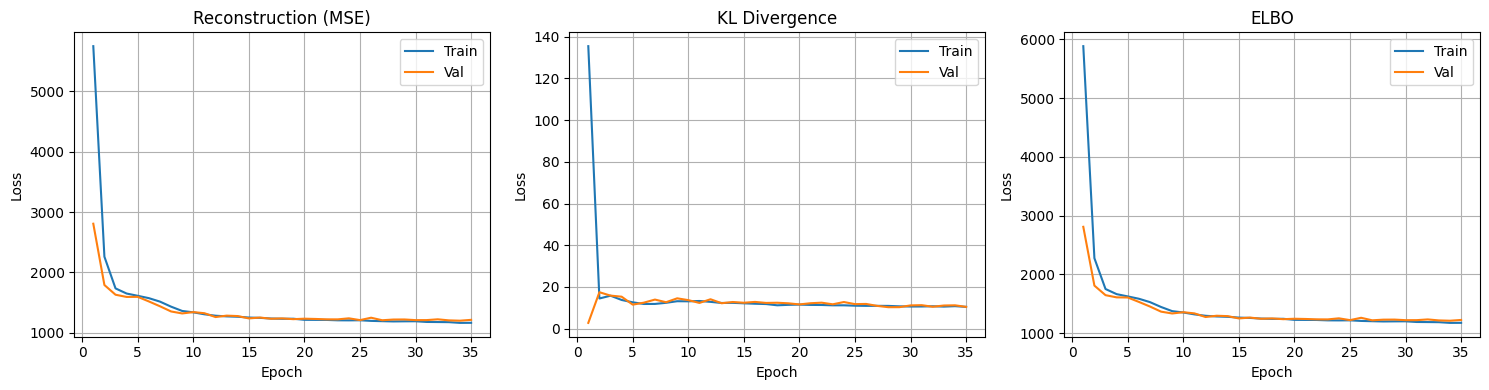

In [36]:
epochs = range(1, len(history_base_mse_2d_gray.history["elbo"]) + 1)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Let's plot our MSE
axes[0].plot(epochs, history_base_mse_2d_gray.history["mse"], label="Train")
axes[0].plot(epochs, history_base_mse_2d_gray.history["val_val-mse"], label="Val")
axes[0].set_title("Reconstruction (MSE)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# Then we plot our KL
axes[1].plot(epochs, history_base_mse_2d_gray.history["kl"], label="Train")
axes[1].plot(epochs, history_base_mse_2d_gray.history["val_val-kl"], label="Val")
axes[1].set_title("KL Divergence")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

# And finally the ELBO [MSE + KL]
axes[2].plot(epochs, history_base_mse_2d_gray.history["elbo"], label="Train")
axes[2].plot(epochs, history_base_mse_2d_gray.history["val_val-elbo"], label="Val")
axes[2].set_title("ELBO")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


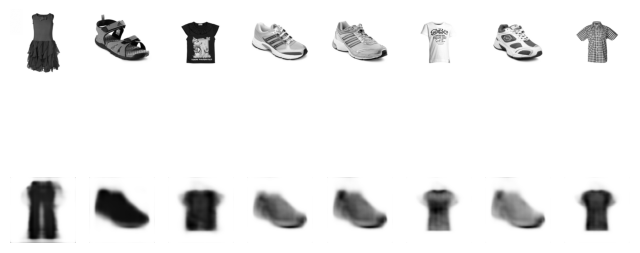

In [40]:
recon_base_2d_gray = vae_base_mse_2d_gray.predict(x_test[:8])

plt.figure(figsize=(8,4))
for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(x_test[i], cmap='gray')
    plt.axis("off")

    plt.subplot(2,8,i+9)
    plt.imshow(recon_base_2d_gray[i], cmap='gray')
    plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


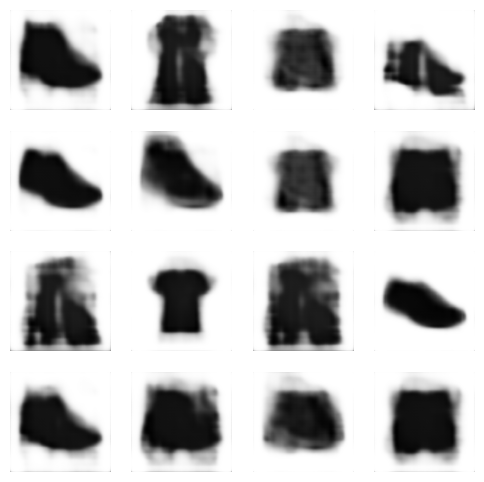

In [45]:
z_samples = np.random.normal(size=(16, 2)).astype("float32")

generated = decoder_base_mse_2d_gray.predict(z_samples)

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(generated[i], cmap='gray')
    plt.axis("off")
plt.show()